In [ ]:
import os
import cv2
import time
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

In [ ]:
data, labels = [], []
for dirname, _, filenames in os.walk('/kaggle/input/face-classification/data/train'):
    for filename in filenames:
        img = cv2.imread(os.path.join(dirname, filename))
        img = cv2.resize(img, (64, 64))
        labels.append(dirname.split("/")[6])
        data.append(img)


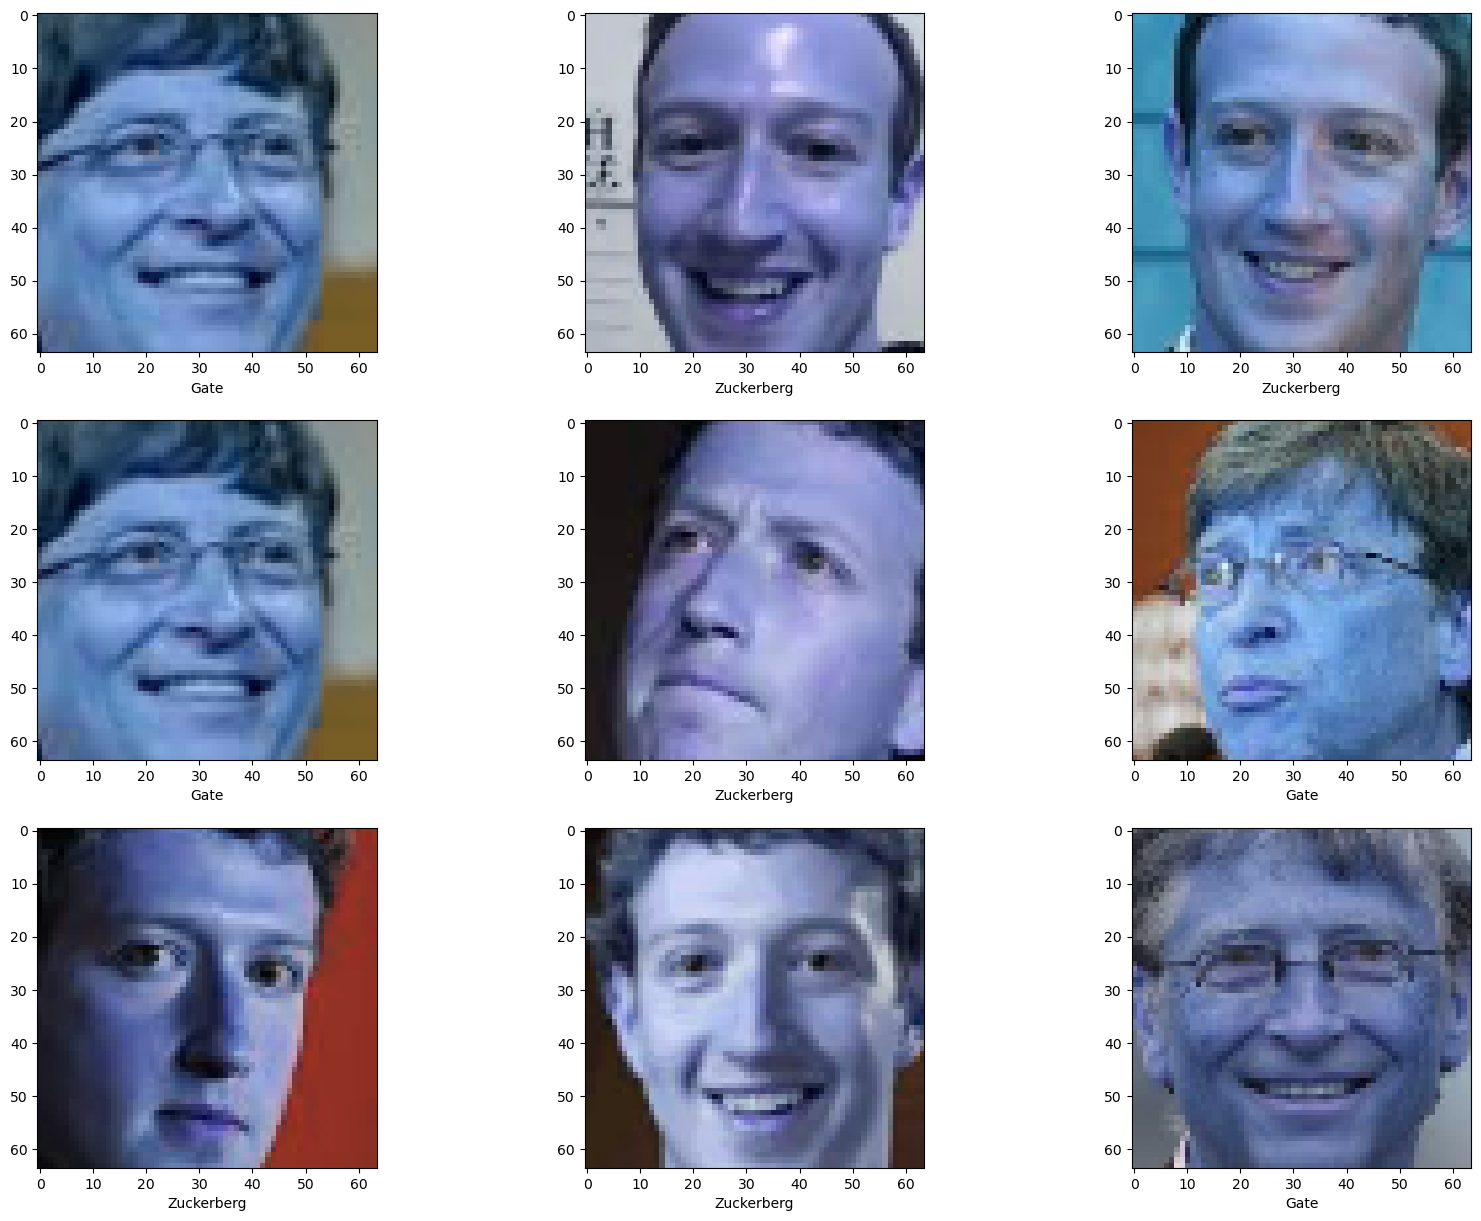

In [ ]:
fig = plt.figure(figsize=(20,15))
for i in range(1,10):
    index = random.randint(0,len(data))
    plt.subplot(3,3,i)
    plt.imshow(data[index])
    plt.xlabel(labels[index].split("_")[1])
plt.show()

In [ ]:
le = LabelEncoder()
Labels= le.fit_transform(labels)

In [ ]:
data_gray = [cv2.cvtColor(data[i] , cv2.COLOR_BGR2GRAY) for i in range(len(data))]

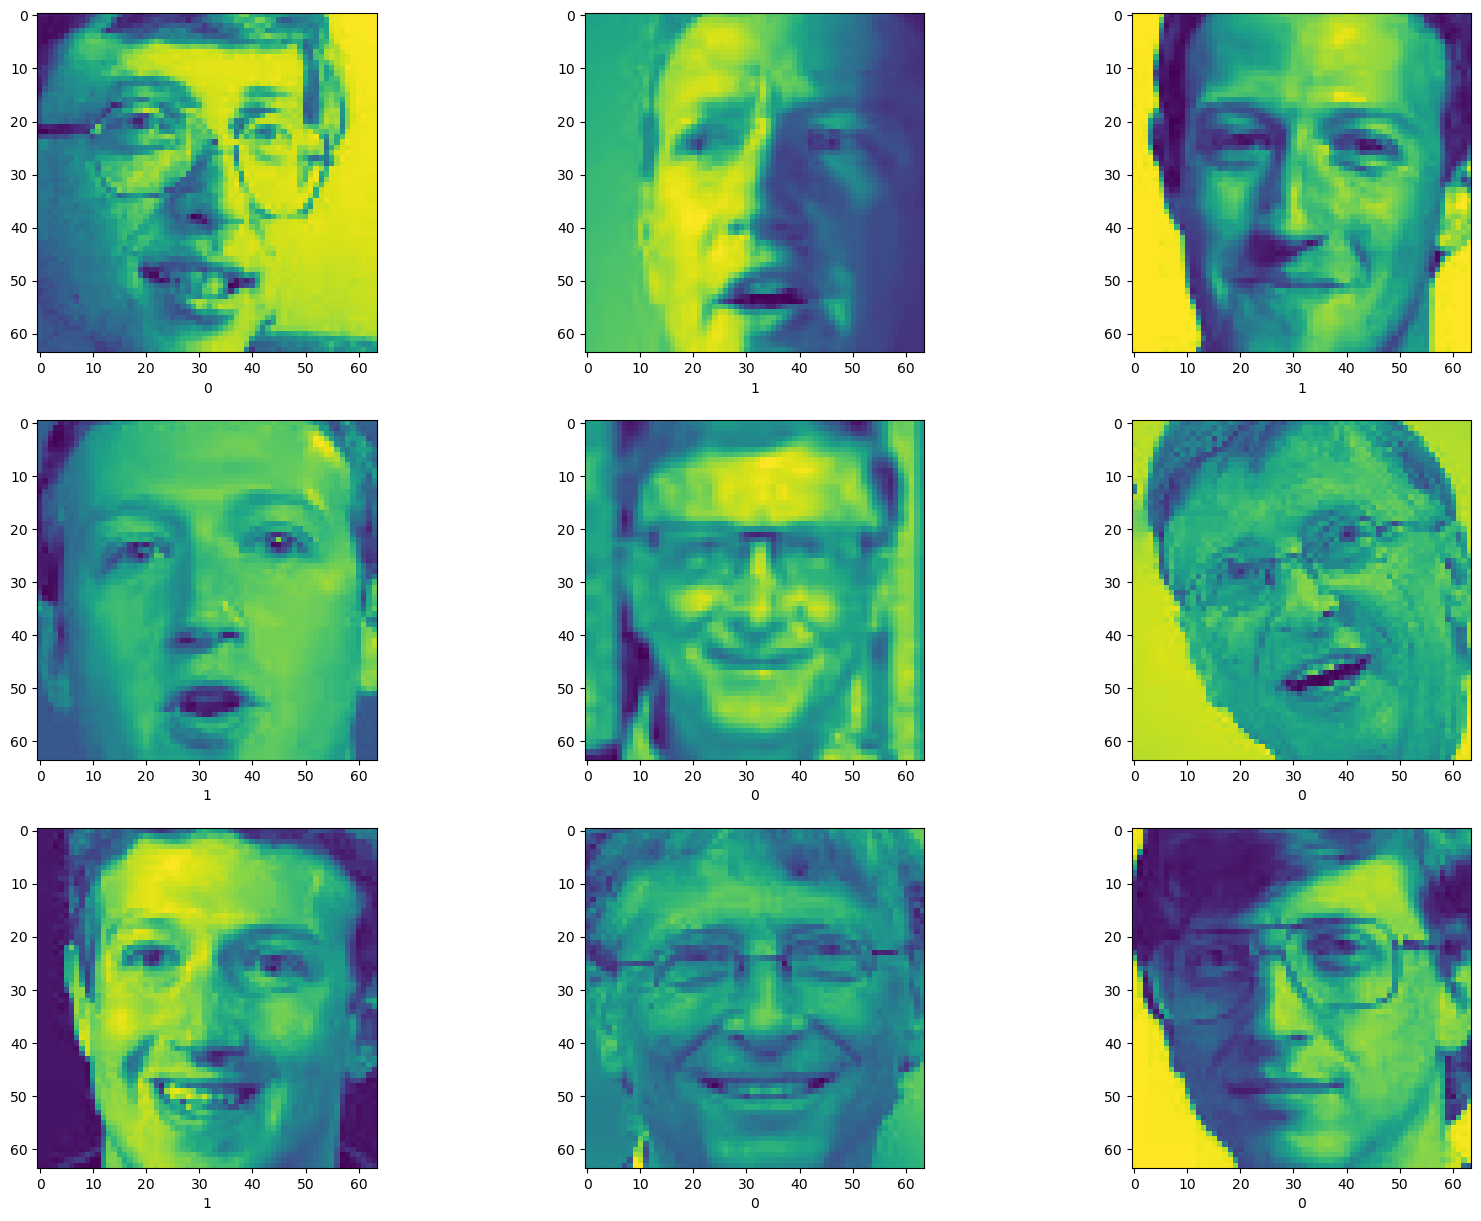

In [ ]:
fig = plt.figure(figsize=(20,15))

for i in range(1,10):
    index = random.randint(1,len(data_gray))
    plt.subplot(3,3,i)
    plt.imshow(data_gray[index])
    plt.xlabel(Labels[index])
plt.show()

In [ ]:
# Create SIFT
sift = cv2.SIFT_create()

In [ ]:
sift_features = []
for image in tqdm(data_gray):
    keypoints, descriptors = sift.detectAndCompute(image, None)
    sift_features.append(descriptors)

100%|██████████| 480/480 [00:01<00:00, 285.87it/s]


In [ ]:
# Use Bag of Visual Words to standardize SIFT features
k = 100  # Number of words in the dictionary
bovw_features = []
kmeans = KMeans(n_clusters=k).fit(np.vstack(sift_features))

In [ ]:
for features in sift_features:
    histogram = np.zeros(k)
    if features is not None:
        clusters = kmeans.predict(features)
        for cluster in clusters:
            histogram[cluster] += 1
    bovw_features.append(histogram)

bovw_features = np.array(bovw_features)

In [ ]:
#Split the data set into training set and test set
X_train, X_test, Y_train, Y_test = train_test_split(bovw_features,
                                                    Labels.ravel(),
                                                    test_size=0.3,
                                                    random_state=0,
                                                    stratify=Labels.ravel())

In [ ]:
# Train the SVM model
svm = SVC(kernel='linear', class_weight='balanced', C=1000, gamma=0.0082)
svm.fit(X_train, Y_train)

SVC(C=1000, class_weight='balanced', gamma=0.0082, kernel='linear')

In [ ]:
# Evaluate the model
print("Score: %0.3f" % (svm.score(X_test, Y_test)))

Score: 0.826


In [ ]:
y_pred = svm.predict(X_test)
print("Accuracy: " + str(accuracy_score(Y_test, y_pred)))
print('\n')
print(classification_report(Y_test, y_pred))

Accuracy: 0.8263888888888888


              precision    recall  f1-score   support

           0       0.87      0.79      0.83        78
           1       0.78      0.86      0.82        66

    accuracy                           0.83       144
   macro avg       0.83      0.83      0.83       144
weighted avg       0.83      0.83      0.83       144



In [ ]:
from joblib import dump
# Save the SVM model as a pickle file
dump(svm, 'SIFT + SVM.pkl')

['SIFT + SVM.pkl']

In [ ]:
#Photoprediction
def predict_image(image_path):
    # Read new image and convert to grayscale image
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Extract SIFT features of grayscale images
    keypoints, descriptors = sift.detectAndCompute(gray, None)

    # Use the built dictionary to standardize SIFT features
    histogram = np.zeros(k)
    if descriptors is not None:
        clusters = kmeans.predict(descriptors)
        for cluster in clusters:
            histogram[cluster] += 1
    bovw_features = np.array(histogram).reshape(1, -1)

    # Use the SVM model to predict the class of a new image
    predicted_class = le.inverse_transform(svm.predict(bovw_features))

    # Display image and prediction results on the same image
    fig, ax = plt.subplots()
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_title(f'Predicted class: {predicted_class}')
    plt.show()

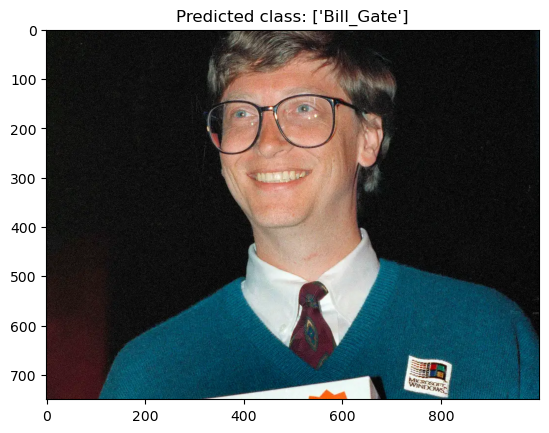

In [ ]:
predict_image('/kaggle/input/bill-test/bill_test.png')